# This file generates the figures from the Effective Stochastic Local Volatility Paper

Load all functionalities

In [1]:
import autograd.numpy as np
import warnings
import helper_functions
import set_parametrization as set_param
from EMP_Algorithms import emp_base_setting as emp_base
from SLV_Algorithms import calibration_scheme_slv_nSABR as slvnSABR_calib
import emp_figure_maker as fig_maker

Set common parameter for the first figures

In [2]:
# parameters PDE scheme 
nsteps = 160
tsteps = 20
nd = 5

# Figure 1

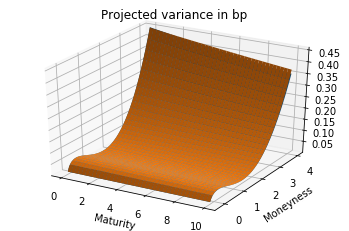

In [3]:
# set time grid
grid_size_time = 0.25
time_grid = np.arange(0,10+grid_size_time,grid_size_time)

# set strike grid
grid_size_strike = 0.0002
strike_grid = np.arange(-0.001,0.02+grid_size_strike,grid_size_strike)

# set a finer strike grid 
grid_size_strike_finer = grid_size_strike/2
strike_grid_finer = np.arange(-0.001,0.02 + grid_size_strike_finer,grid_size_strike_finer)

# generate dZABR market data
params_market = set_param.set_ZABR_standard_parameters_slv_surface()
market_surface = emp_base.get_emp_locvol_surface(time_grid,strike_grid,params_market)

# Fitting maturity
T_fit = 1
index_T_fit = helper_functions.index_search_time(T_fit,time_grid)
projvol_market_fit = market_surface[index_T_fit,:][0]

# Exersice date
T_ex = 10
index_T_ex = helper_functions.index_search_time(T_ex,time_grid)
projvol_market_ex = market_surface[index_T_ex,:][0]

# set the base parametrization for the slv-nSABR model
forward_base = params_market.forward
displacement_base = params_market.displacement
alpha_base = 0.02
nu_base = 0.2
rho_base = -0.5

# calibrate the slv-nSABR model to the surface
params_slvnSABR = slvnSABR_calib.calibrate_slv_nSABR(market_surface, T_fit,
                                                     forward_base, alpha_base,
                                                     nu_base, rho_base,
                                                     strike_grid,
                                                     time_grid,
                                                     displacement_base)

# compute the modelled projected variance surface
projvol_slv = helper_functions.compute_slv_locvol_surface(time_grid,strike_grid,params_slvnSABR)
projvol_slv_finer = helper_functions.compute_slv_locvol_surface(time_grid,strike_grid_finer,params_slvnSABR)

# plot the surface
fig_maker.make_figure_slv_1(projvol_slv, market_surface, strike_grid/params_market.forward, time_grid)


# Figure 2

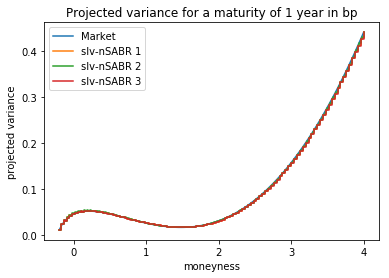

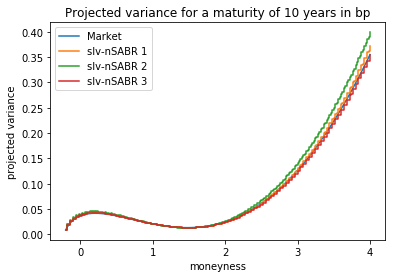

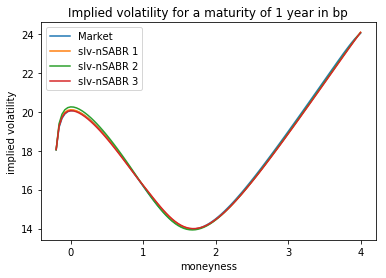

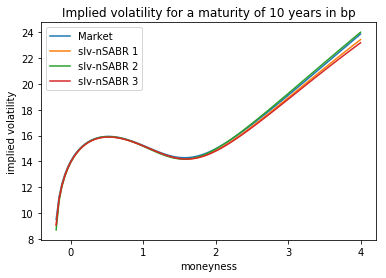

In [4]:
# consider three different initial base parametrizations
curve_cases = ["slv-nSABR 1", "slv-nSABR 2", "slv-nSABR 3"]
curve_cases_nu = [nu_base, 0.4, 0.1]
curve_cases_rho = [rho_base, -0.7, -0.5]

# computed curves
curves_iv_fit = np.empty((len(curve_cases),len(strike_grid)))
curves_iv_ex = np.empty((len(curve_cases),len(strike_grid)))
curves_projvol_fit = np.empty((len(curve_cases),len(strike_grid_finer)))
curves_projvol_ex = np.empty((len(curve_cases),len(strike_grid_finer)))

# marked implied volatilities in bp
iv_market_fit = helper_functions.compute_hagan_pde_iv_slv_setup(T_fit,strike_grid, nsteps, tsteps, nd, params_market)
iv_market_ex = helper_functions.compute_hagan_pde_iv_slv_setup(T_ex,strike_grid, nsteps, tsteps, nd, params_market)


# calibrate the different parametrizations and compute the implied volatilities
for case in np.arange(0,len(curve_cases)):
    
    # calibrate model
    params_slvnSABR = slvnSABR_calib.calibrate_slv_nSABR(market_surface, T_fit,
                                                         forward_base, alpha_base,
                                                         curve_cases_nu[case],
                                                         curve_cases_rho[case],
                                                         strike_grid,
                                                         time_grid,
                                                         displacement_base)
    
    # compute projected volatilities
    projvol_slv = helper_functions.compute_slv_locvol_surface(time_grid, strike_grid_finer, params_slvnSABR)
    curves_projvol_fit[case,:] = projvol_slv[index_T_fit,:][0]
    curves_projvol_ex[case,:] = projvol_slv[index_T_ex,:][0]
    
    # compute the iv
    curves_iv_fit[case,:] = helper_functions.compute_hagan_pde_iv_slv_setup(T_fit, strike_grid, nsteps, tsteps, nd, params_slvnSABR)
    curves_iv_ex[case,:] = helper_functions.compute_hagan_pde_iv_slv_setup(T_ex, strike_grid, nsteps, tsteps, nd, params_slvnSABR)

    
# plot the figures
fig_maker.make_figure_slv_2_projvol(curves_projvol_fit, strike_grid_finer/params_market.forward,
                                    projvol_market_fit, strike_grid/params_market.forward,
                                    curve_cases, T_fit)

fig_maker.make_figure_slv_2_projvol(curves_projvol_ex, strike_grid_finer/params_market.forward,
                                    projvol_market_ex, strike_grid/params_market.forward,
                                    curve_cases, T_ex)

fig_maker.make_figure_slv_2_iv(curves_iv_fit, strike_grid/params_market.forward,
                               iv_market_fit, strike_grid/params_market.forward,
                               curve_cases, T_fit)

fig_maker.make_figure_slv_2_iv(curves_iv_ex, strike_grid/params_market.forward,
                               iv_market_ex, strike_grid/params_market.forward,
                               curve_cases, T_ex)
